## Load the dataset

In [1]:
import json, gzip
import numpy as np

aa2idx = {'A':0, 'R':1, 'N':2, 'D':3, 'C':4, 'Q':5, 'E':6, 'G':7, 'H':8, 'I':9,
          'L':10, 'K':11, 'M':12, 'F':13, 'P':14, 'S':15, 'T':16, 'W':17, 'Y':18, 'V':19}

# read .json file
with gzip.open('../data/phipsi.json.gz', 'rb') as f:
    dataset = json.load(f)

# reduse dataset to a list for simpler access
dataset = dataset['phipsi10882']

# convert data to numpy arrays skipping first and last residues
for item in dataset:
    n = len(item['sequence'])
    item['sequence'] = np.array([aa2idx[aa] for aa in item['sequence'][1:n-1]], dtype=np.int8)
    item['phi'] = np.array(item['phi'], dtype=np.float32)[1:n-1]
    item['psi'] = np.array(item['psi'], dtype=np.float32)[1:n-1]

Angular data needs special treatment. Eg, angles -179° and 179° are actually close to each other (only 2° difference), but far apart if the difference is calculated directly from the given angles (358°). To avoid such problems, we covert every dihedral (&phi;,&psi;) into angle vector **v**=(cos(&phi;),sin(&phi;),cos(&psi;),sin(&psi;)) 

In [2]:
for item in dataset:
    item['avec'] = np.vstack([
        np.sin(item['phi']).T,
        np.cos(item['phi']).T,
        np.sin(item['psi']).T,
        np.cos(item['psi']).T ]).T

## K-means clusters from angle vectors

In [3]:
from sklearn.cluster import KMeans

# use only 1/50 of the full dataset to make things faster
X = np.vstack([item['avec'] for item in dataset[::50]])

# split all (phi,psi) pairs into 25 clusters
kmeans = KMeans(n_clusters=25, max_iter=5)
kmeans.fit(X)

# assign every (phi,psi) pair to one of the inferred clusters
X_pred = kmeans.predict(X)

```kmeans``` stores clustering results, including centers of the clusters. We extract them and convert from sin/cos representation back to angles (in radians).

In [4]:
cent = kmeans.cluster_centers_
cphi = np.arctan2(cent[:,0], cent[:,1])
cpsi = np.arctan2(cent[:,2], cent[:,3])

## Visualize clusters

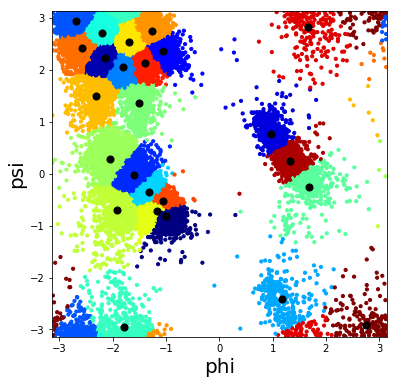

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# stack phi and psi from all proteins together
# (again, use 1/50 of the full set)
phi = np.hstack([item['phi'] for item in dataset[::50]])
psi = np.hstack([item['psi'] for item in dataset[::50]])

matplotlib.rcParams['image.cmap'] = 'jet'

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.xlabel('phi', fontsize=20)
plt.ylabel('psi', fontsize=20)
plt.scatter(phi, psi, c=X_pred, s=10)
plt.scatter(cphi, cpsi, c='black', s=50)
plt.show()